#### Import Dependencies
- First section is set out to import all required dependencies and to read raw_csv file into dataframe 

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# READ IN CSV as raw_csv
raw_csv = pd.read_csv("Resources/PS_20174392719_1491204439457_log.csv")
raw_csv.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


##### Exploring existing data set:
The following section explores the raw data `raw_csv` to identify cleaning required .
- In this section we review the existing data set.

In [3]:
# Explore csv info
raw_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
# Explore unique variables
unique_counts=raw_csv.nunique()
print(unique_counts)

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64


In [5]:
# Explore  Distribution of numerical data.
distribution_summary  = raw_csv.describe()
print(distribution_summary )

               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.000000e+00    0.000000e+00

In [6]:
# Explore Distribution of Categorical Data
# Generate the distribution summary for categorical columns
categorical_summary = {}
for col in raw_csv.select_dtypes(include=['object']):
    categorical_summary[col] = raw_csv[col].value_counts()

# Display the distribution summary for categorical columns
for col, counts in categorical_summary.items():
    print(f"\nDistribution for column '{col}':")
    print(counts)



Distribution for column 'type':
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

Distribution for column 'nameOrig':
C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
              ..
C98968405      1
C720209255     1
C1567523029    1
C644777639     1
C1280323807    1
Name: nameOrig, Length: 6353307, dtype: int64

Distribution for column 'nameDest':
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
              ... 
M1470027725      1
M1330329251      1
M1784358659      1
M2081431099      1
C2080388513      1
Name: nameDest, Length: 2722362, dtype: int64


In [7]:
# Explore if Null exists
raw_csv.isnull().values.any()

False

#### Data Clean and Create New Features

In [8]:
### NEW FEATURES based on Step : Hour  Cycle and Week

## Create hour cycle to reset to 1 every 24 steps
raw_csv['hour'] = ((raw_csv['step'] - 1) % 24) + 1

## Create Cycle every 24 Hours
# Create a new column 'new_column' initialized with 1
raw_csv['day'] = 1

# Calculate the increments of 1 for every 24 increases in the 'step' column
raw_csv['day'] += (raw_csv['step'] - 1) // 24


# Create a new column 'week' by increasing 1 for each cycle
raw_csv['week'] = ((raw_csv['step'] - 1) // 168) + 1

# Drop the intermediate 'cycles' column if needed
# raw_csv.drop(columns=['cycles'], inplace=True)

raw_csv.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,day,week
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1,1,1
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1,1,1
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1,1,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,1,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1,1,1


In [9]:
### NEW FEATURES based on old and new balance

# Create new columns for the division of 'amount' by 'oldbalanceOrg'
raw_csv['trans_weight'] = raw_csv['amount'] / raw_csv['oldbalanceOrg']

# % Change in Balance Transaction 
raw_csv['bal_change_per'] = (raw_csv['newbalanceOrig']-   raw_csv['oldbalanceOrg'])/ raw_csv['oldbalanceOrg']
raw_csv.head()

# Create Large Transaction Figure
raw_csv['large_transaction'] = (raw_csv['amount'] > 100000).astype(int)



In [10]:
### NEW FEATURES Creating Dummies bases on 'type'
# Create dummy variables for the 'type' column
dummy_columns = pd.get_dummies(raw_csv['type'], prefix='type')

# Concatenate the dummy variables with the original DataFrame
raw_csv = pd.concat([raw_csv, dummy_columns], axis=1)

# Display the updated DataFrame with the dummy columns
raw_csv.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,day,week,trans_weight,bal_change_per,large_transaction,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,...,1,1,0.057834,-0.057834,0,0,0,0,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,...,1,1,0.087735,-0.087735,0,0,0,0,1,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,...,1,1,1.000000,-1.000000,0,0,0,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,...,1,1,1.000000,-1.000000,0,0,1,0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,...,1,1,0.280795,-0.280795,0,0,0,0,1,0


In [11]:
## PRINT the cleaned data to csv fraud_det_df
fraud_det_df = raw_csv.copy()

# Export the DataFrame as a CSV file. 
# fraud_det_df.to_csv("Resources/fraud_det_df.csv", encoding='utf8', index=False)
fraud_det_df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,day,week,trans_weight,bal_change_per,large_transaction,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,...,1,1,0.057834,-0.057834,0,0,0,0,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,...,1,1,0.087735,-0.087735,0,0,0,0,1,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,...,1,1,1.000000,-1.000000,0,0,0,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,...,1,1,1.000000,-1.000000,0,0,1,0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,...,1,1,0.280795,-0.280795,0,0,0,0,1,0


In [18]:
fraud_det_df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'hour', 'day', 'week', 'trans_weight',
       'bal_change_per', 'large_transaction', 'type_CASH_IN', 'type_CASH_OUT',
       'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')

#### Data Summary and Visualisation

In [15]:
## Show Summary of isFraud Type 
type_summary = pd.crosstab(fraud_det_df['type'], fraud_det_df['isFraud'])
type_summary

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


In [19]:
## Show Summary of isFraud Type 
type_summary = pd.crosstab(fraud_det_df['type'], fraud_det_df['isFlaggedFraud'])
type_summary

isFlaggedFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2237500,0
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,532893,16


In [16]:
## Show Summary of isFraud hour 
hour_summary = pd.crosstab(fraud_det_df['hour'], fraud_det_df['isFraud'])
hour_summary

isFraud,0,1
hour,,
1,26753,358
2,8646,372
3,1681,326
4,967,274
5,1275,366
6,3062,358
7,8660,328
8,26547,368
9,283177,341


In [17]:
## Show Summary of isFraud hour 
week_summary = pd.crosstab(fraud_det_df['week'], fraud_det_df['isFraud'])
week_summary

isFraud,0,1
week,,
1,1928276,1904
2,2852732,1863
3,1277407,1854
4,230343,1792
5,65649,800


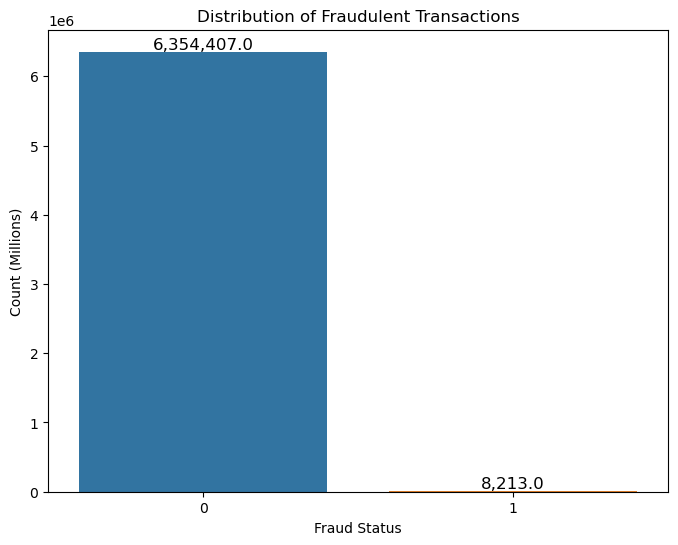

0    6354407
1       8213
Name: isFraud, dtype: int64


In [12]:
# Plot the distribution of 'fraud_status' with labels and y-axis in millions
# Plot the distribution of 'fraud_status' with labels and y-axis in millions
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
ax = sns.countplot(data=fraud_det_df, x='isFraud')

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():,}", (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

plt.title("Distribution of Fraudulent Transactions")
plt.xlabel("Fraud Status")
plt.ylabel("Count (Millions)")
plt.show()

##
count_fraud = fraud_det_df['isFraud'].value_counts()
print(count_fraud)

Exploratory Data Analysis and EDA and Fraud detection

The provided data has the financial transaction data as well as the target variable isFraud, which is the actual fraud status of the transaction and isFlaggedFraud is the indicator which the simulation is used to flag the transaction using some threshold.

The goal should be how we can improve and come up with better threshold to capture the fraud transaction.